<a href="https://colab.research.google.com/github/WebDev-Alex/ProiectIAPI/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Scanner de documente cu OpenCV
**Autor:** Tușinean Alexandru Gabriel  
**Curs:** Inteligență Artificială în Prelucrarea Imaginilor

Acest proiect implementează un *document scanner* folosind tehnici clasice de procesare a imaginilor (OpenCV):
- detecție contururi (Canny) + morfologie
- selecția celui mai mare dreptunghi (pagina)
- corecție de perspectivă (warp)


Codul functioneaza cu poze sau folosind camera. In google Collab nu functioneaza camera. Pentru a incerca aceasta varianta e nevoie sa se ruleze codul local.<BR><br>
Am adaugat niste poze in folderul de pe github pentru a fi mai usor de testat aplicatia

## Importuri

Acest proiect folosește următoarele biblioteci:

- `opencv-python`: Pentru operații de procesare a imaginilor.
- `ipywidgets`: Pentru a crea elemente interactive, cum ar fi slidere și butoane de încărcare fișiere.
- `reportlab`: Pentru a genera fișiere PDF.
- `google.colab.patches.cv2_imshow`: Pentru a afișa imagini OpenCV în Google Colab.
- `google.colab.files`: Pentru a permite încărcarea și descărcarea fișierelor în Google Colab.
- `numpy`: Pentru operații numerice, în special cu matrici.
- `os`: Pentru a interacționa cu sistemul de operare, cum ar fi crearea de directoare.
- `io`: Pentru a lucra cu stream-uri de date.
- `zipfile`: Pentru a crea și manipula arhive ZIP.
- `sys`: Pentru a accesa parametri și funcționalități specifice sistemului.
- `reportlab.pdfgen.canvas`: Clasa principală pentru crearea de documente PDF.
- `reportlab.lib.pagesizes`: Definește dimensiuni standard ale paginilor (ex: A4).
- `PIL (Pillow)`: Pentru manipularea imaginilor, utilizată aici pentru a redimensiona imaginile înainte de a le adăuga în PDF.text cursiv

In [22]:
!pip -q install opencv-python ipywidgets reportlab
from google.colab.patches import cv2_imshow
from google.colab import files
import ipywidgets as widgets
import numpy as np, cv2, os, zipfile, sys
from reportlab.pdfgen import canvas
from reportlab.lib.pagesizes import A4
from PIL import Image

## Modul de utilizare al aplicatiei
Aici verificam daca putem folosi camera.
In cazul in care aplicatia este rulata in google.colab, modul de camera este dezactivat, singura optiune fiind incarcarea de imagini cu documente.

In [32]:
USE_CAMERA = True
CAM_INDEX = 0

def disable_camera_in_colab():
    if 'google.colab' in sys.modules:
        print("Google Colab detectat → camera este dezactivată.")
        return True
    return False

if disable_camera_in_colab():
    USE_CAMERA = False


Google Colab detectat → camera este dezactivată.


## stackImages
Funcția **stackImages** primește o listă de imagini, redimensionează fiecare la aceeași scară și le combină orizontal și vertical într-un colaj.<br>
Funcția desenează dreptunghiuri albe și textul corespunzător (label) în partea superioară a fiecărei celule.<br><br>
Functia este folosita pentru a afisa fiecare etapa prin care trec imaginile.

In [33]:
def stackImages(imgArray, scale, lables=[]):
    rows, cols = len(imgArray), len(imgArray[0])
    isGrid = isinstance(imgArray[0], list)
    if isGrid:
        for r in range(rows):
            for c in range(cols):
                im = cv2.resize(imgArray[r][c], (0,0), fx=scale, fy=scale)
                if im.ndim == 2: im = cv2.cvtColor(im, cv2.COLOR_GRAY2BGR)
                imgArray[r][c] = im
        ver = np.vstack([np.hstack(r) for r in imgArray])
    else:
        ver = np.hstack([cv2.cvtColor(cv2.resize(i,(0,0),fx=scale,fy=scale),
                        cv2.COLOR_GRAY2BGR) if i.ndim==2 else
                        cv2.resize(i,(0,0),fx=scale,fy=scale) for i in imgArray])
    if lables:
        h, w = ver.shape[:2]
        ch, cw = h//rows, w//cols
        for r in range(rows):
            for c in range(cols):
                if r < len(lables) and c < len(lables[r]):
                    t = lables[r][c]; x,y = c*cw, r*ch
                    cv2.rectangle(ver,(x,y),(x+cw,y+30),(255,255,255),cv2.FILLED)
                    cv2.putText(ver,t,(x+10,y+20),cv2.FONT_HERSHEY_SIMPLEX,0.6,(0,0,0),2)
    return ver

## reorder
Functia **reorder** rearanjează coordonatele celor patru puncte ale conturului detectat, astfel încât acestea să aibă o ordine corectă pentru transformarea de perspectivă.<br><br>
Funcția primește un tablou cu patru puncte care reprezintă colțurile unei foi detectate. Pentru a corecta ordinea acestora (stânga sus, dreapta sus, stânga jos, dreapta jos), funcția calculează suma și diferența coordonatelor fiecărui punct:

In [34]:
def reorder(pts):
    pts=pts.reshape((4,2))
    out=np.zeros((4,1,2),dtype=np.int32)
    s=pts.sum(1); d=np.diff(pts,axis=1)
    out[0]=pts[np.argmin(s)]; out[3]=pts[np.argmax(s)]
    out[1]=pts[np.argmin(d)]; out[2]=pts[np.argmax(d)]
    return out

## **biggestContour**
Identifică cel mai mare contur dintr-o imagine care are exact patru colțuri, considerat ca fiind conturul foii/documentului.<br><br>
Funcția parcurge toate contururile detectate în imagine și calculează aria fiecăruia. Se ignoră contururile mici (sub 5000 pixeli) pentru a evita zgomotul.
Pentru fiecare contur suficient de mare, se determină perimetrul și se aplică funcția cv2.approxPolyDP() pentru a aproxima forma. Dintre toate formele, este selectată cea mai mare care are exact 4 vârfuri, adică un posibil dreptunghi — conturul documentului. Se returnează atât conturul respectiv, cât și aria sa.

In [35]:
def biggestContour(contours):
    best,area=np.array([]),0
    for c in contours:
        a=cv2.contourArea(c)
        if a>5000:
            peri=cv2.arcLength(c,True)
            approx=cv2.approxPolyDP(c,0.02*peri,True)
            if len(approx)==4 and a>area: best,area=approx,a
    return best,area

## **drawRectangle / illumination_fix**

**drawRectangle** Desenează un dreptunghi între cele patru puncte care definesc colțurile detectate ale foii. Folosit pentru a marca visual zona documentului detectat.

**illumination_fix** corectează neuniformitățile de iluminare ale imaginii, eliminând umbrele și variațiile de lumină. Scopul este de a imbunatati calitatea pentru pasul urmator.

In [36]:
def drawRectangle(img,pts,t=2,color=(255,0,0)):
    p=pts.reshape(4,2)
    for i in [(0,1),(0,2),(3,2),(3,1)]:
        cv2.line(img,tuple(p[i[0]]),tuple(p[i[1]]),color,t)
    return img

def illumination_fix(gray,sigma=21):
    bg=cv2.GaussianBlur(gray,(0,0),sigmaX=sigma,sigmaY=sigma)
    norm=cv2.addWeighted(gray,1.5,bg,-0.5,0)
    norm=cv2.normalize(norm,None,0,255,cv2.NORM_MINMAX)
    return cv2.medianBlur(norm,3)


## **detect_and_warp**

Funcția realizează detecția automată a foii într-o imagine, aplică o transformare de perspectivă („warp”) pentru a o corecta geometric, apoi normalizează iluminarea și binarizează rezultatul pentru a obține efectul de „document scanat”.

### Detalii:

*   Redimensionează imaginea la o dimensiune fixă pentru consistență.
*   O convertește în tonuri de gri și aplică un filtru Gaussian pentru reducerea zgomotului.
*   Folosește operatorul Canny ccu două praguri (t1, t2) pentru a identifica muchiile.
*   Extrage toate contururile
*   Alege cel mai mare contur cu patru colțuri prin funcția auxiliară
*   Desenează conturul detectat pe imagine pentru verificare vizuală.
*   Reordonează colțurile conturului folosind reorder(), pentru a obține ordinea corectă a punctelor.
*   Aplică transformarea de perspectivă (cv2.getPerspectiveTransform și cv2.warpPerspective), obținând o imagine „văzută de sus” a foii.
*   Transformă imaginea warp în gri și aplică funcția illumination_fix() pentru a compensa variațiile de lumină (umbre, reflexii).
*   Normalizează contrastul și uniformizează fundalul.
*   Aplică un threshold adaptiv gaussian (cv2.adaptiveThreshold) pentru a separa clar textul de fundal.
*   Elimină imperfecțiunile mici prin operația morfologică cv2.morphologyEx.
*   Returnează un colaj cu toate etapele principale (stackImages()), imaginea warp (corectată geometric) și versiunea finală binarizată (scanată).

In [37]:
def detect_and_warp(img_bgr, t1=200, t2=200, crop=20):
    target=(480,640)
    img=cv2.resize(img_bgr,target)
    gray=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    blur=cv2.GaussianBlur(gray,(5,5),1)
    edges=cv2.Canny(blur,t1,t2)
    k=np.ones((5,5),np.uint8)
    mask=cv2.erode(cv2.dilate(edges,k,2),k,1)
    cnts,_=cv2.findContours(mask,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
    visC,visB=img.copy(),img.copy()
    cv2.drawContours(visC,cnts,-1,(0,255,0),3)
    biggest,_=biggestContour(cnts)
    warped=grayWarp=None;scan=None
    if biggest.size!=0:
        biggest=reorder(biggest)
        drawRectangle(visB,biggest,2,(255,0,0))
        src=np.float32(biggest)
        dst=np.float32([[0,0],[target[0],0],[0,target[1]],[target[0],target[1]]])
        M=cv2.getPerspectiveTransform(src,dst)
        warped=cv2.warpPerspective(img,M,target)
        warped=warped[crop:warped.shape[1]-crop,crop:warped.shape[0]-crop]
        warped=cv2.resize(warped,target)
        grayWarp=cv2.cvtColor(warped,cv2.COLOR_BGR2GRAY)
        norm=illumination_fix(grayWarp)
        scan=cv2.adaptiveThreshold(norm,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,31,10)
        scan=cv2.morphologyEx(scan,cv2.MORPH_OPEN,np.ones((3,3),np.uint8),1)
    tiles=([img,gray,edges,visC],[visB,warped if warped is not None else np.zeros_like(img),
           grayWarp if grayWarp is not None else np.zeros_like(gray),
           scan if scan is not None else np.zeros_like(gray)])
    labels=[["Original","Gray","Edges","Contours"],
            ["Biggest","Warp","WarpGray","Scan"]]
    return stackImages(tiles,0.9,labels),warped,scan


## Interfata

Codul de mai jos implementează o interfață vizuală simplă, dar foarte utilă pentru experimentarea parametrilor algoritmului fără a modifica manual codul.<br><br>
*   Se creaza 2 bare glisante pentru a controla pragurile inferioare si superioare ale operatorului Canny din OpenCV.
*   Reglarea acestora modifica sensbilitatea detectiei marginilor.
*   windgetul de FileUpload pemite incarcarea unor imagini direct din sistemul local.
*   Dupa incarcare, imaginile sunt convertite intr-un tablouastfel incat sa poata fi procesate de OpenCV.
*   process_upload este declangat automat de catre upload.observe, in momentul in care utilizatorul incarca fisiere.
*   Pentru fiecare fisier adaugat, se apeleaza functia detect_and_warp cu valorile curente ale slider-elor.
*   Se afiseaza rezultatele cu cv2_imshow
*   Se salveaza imaginile obtinute in directorul scans.

FileUpload(value={}, accept='image/*', description='Upload', multiple=True)

→ random paper 2.jpg


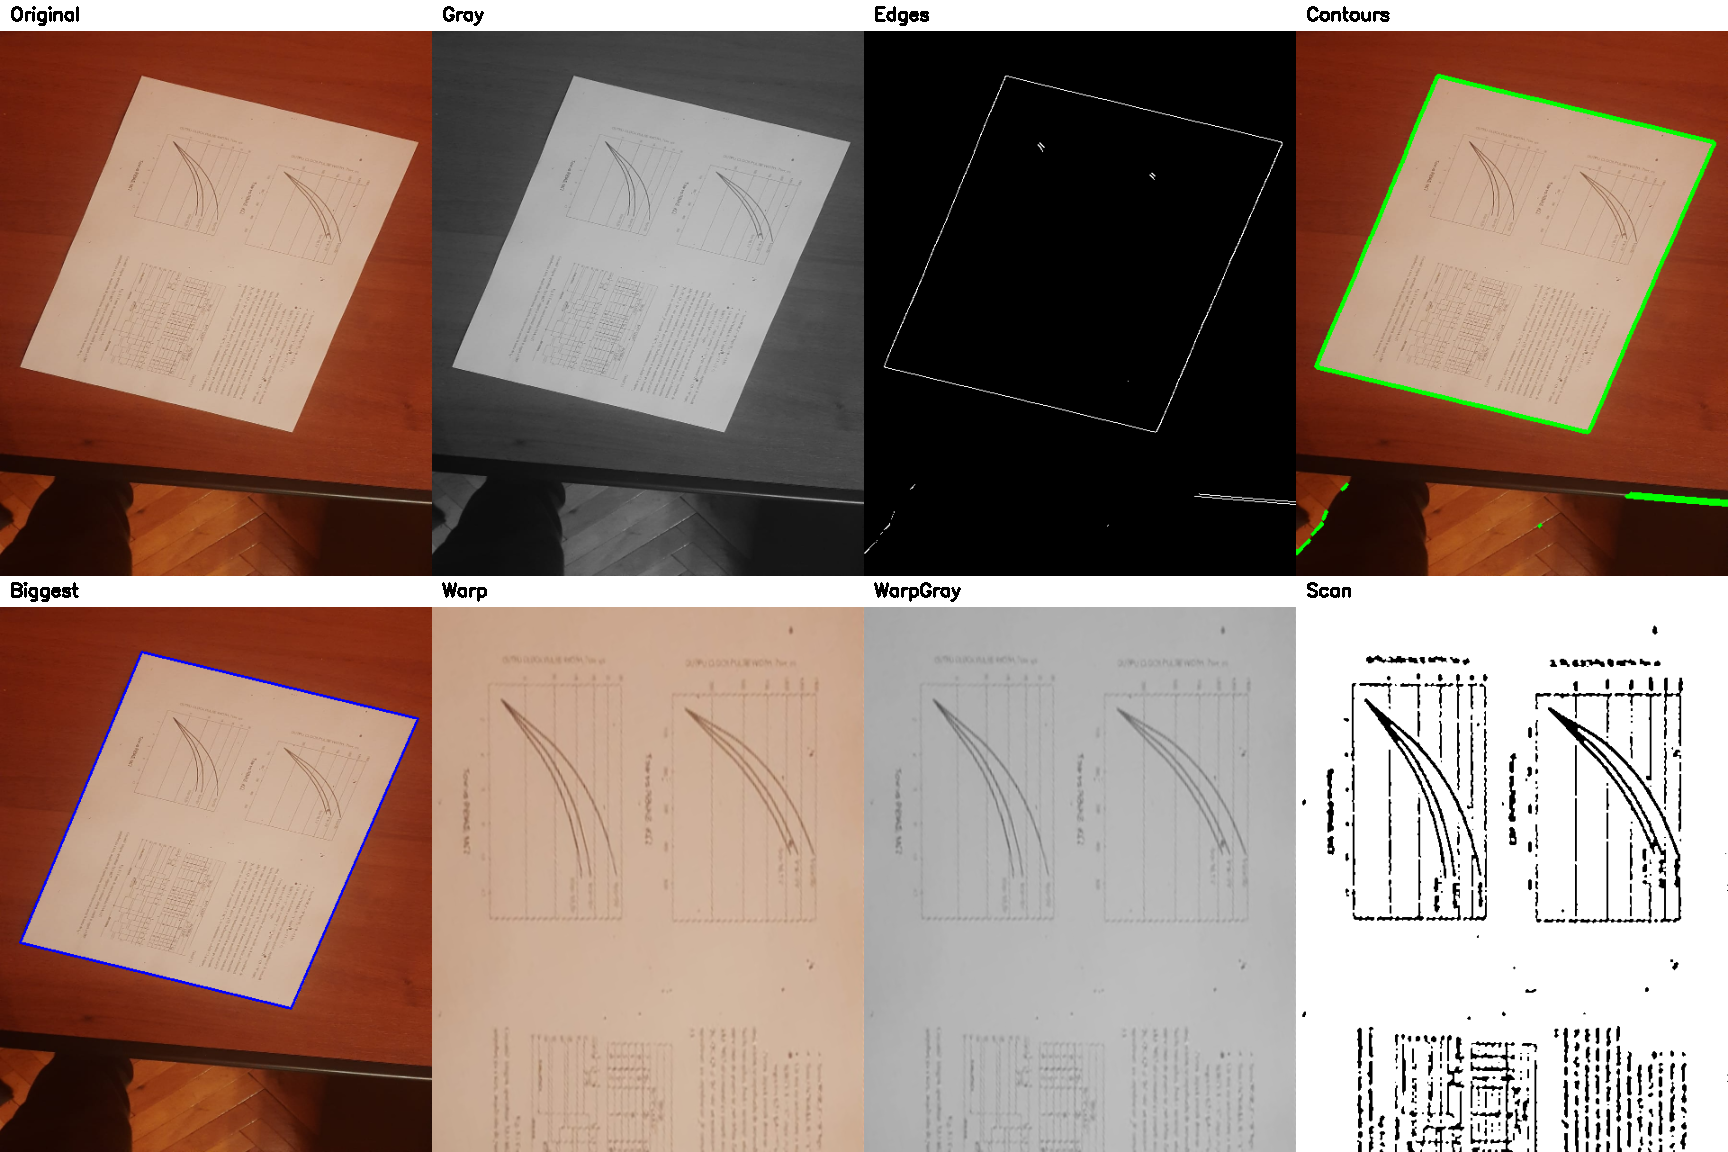

→ random paper 5.jpg


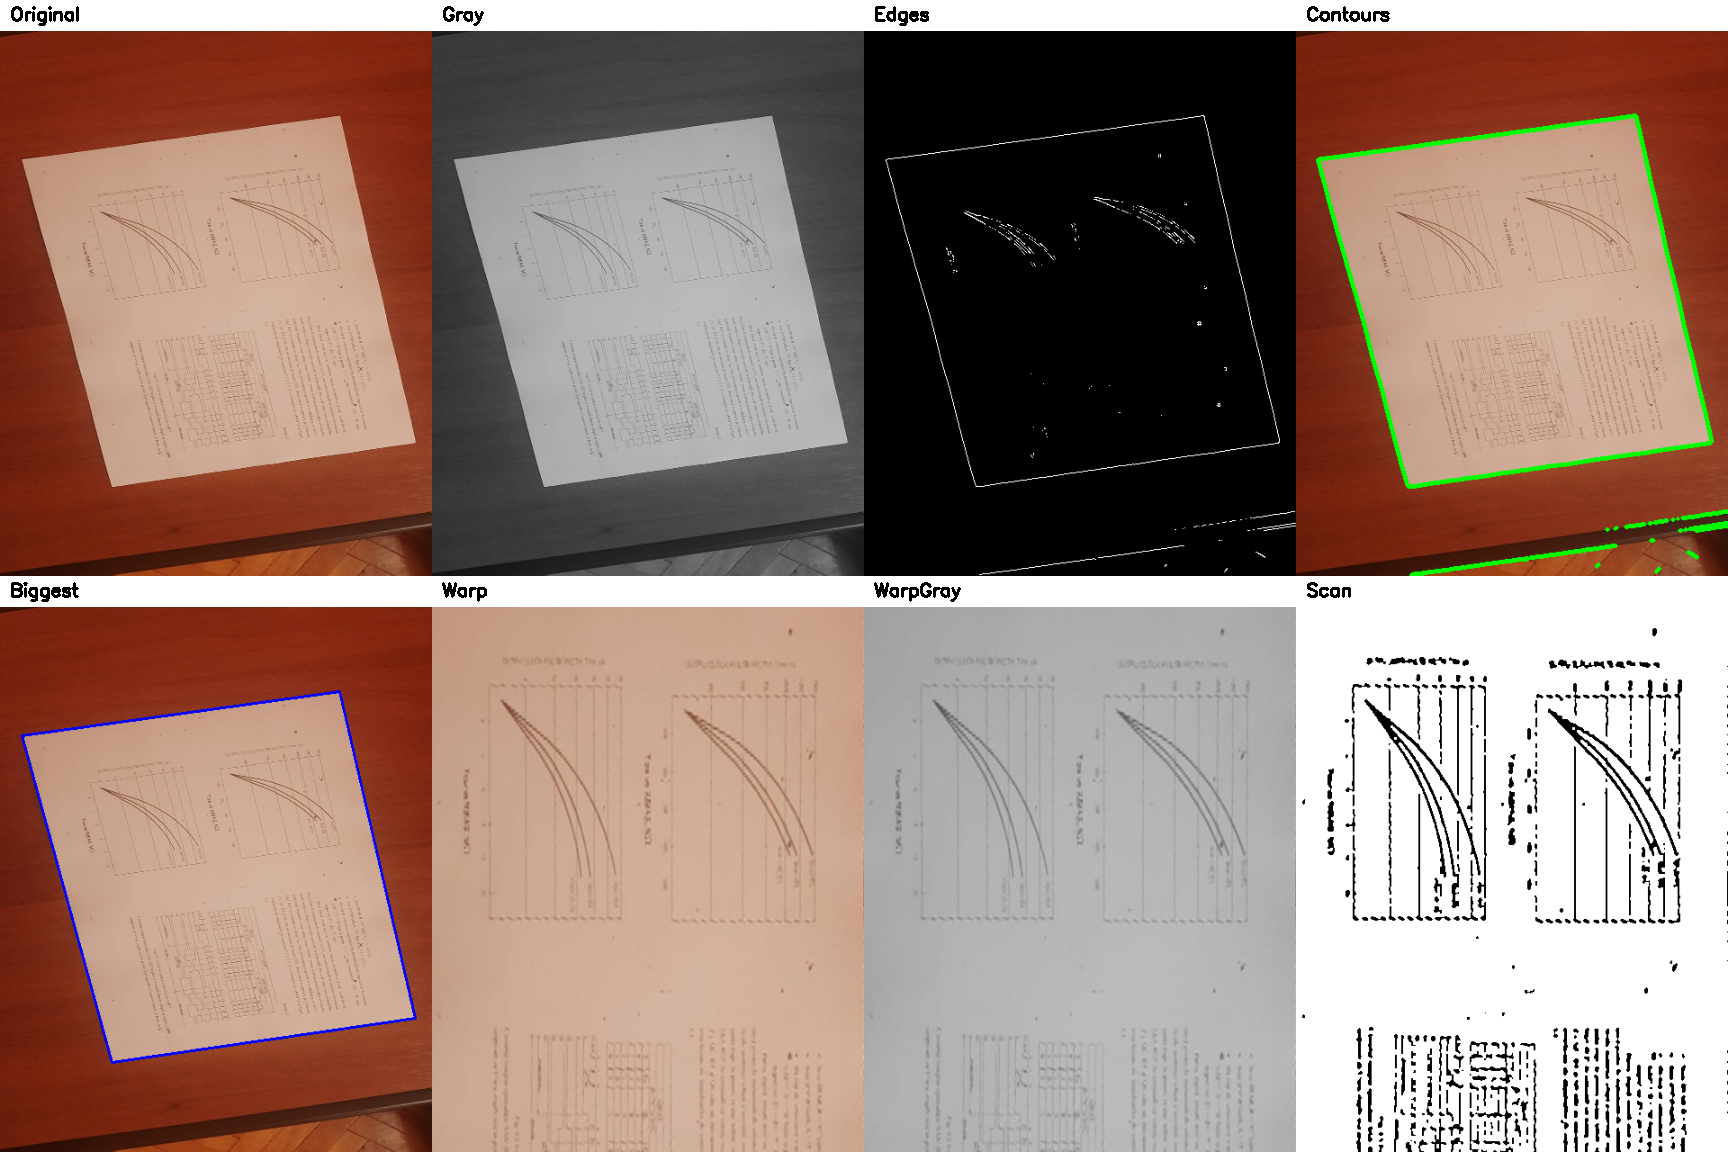

In [29]:
thr1 = widgets.IntSlider(value=200,min=0,max=255,description='Threshold1')
thr2 = widgets.IntSlider(value=200,min=0,max=255,description='Threshold2')
display(widgets.HBox([thr1,thr2]))

upload = widgets.FileUpload(accept='image/*', multiple=True)
display(upload)
os.makedirs("scans", exist_ok=True)

def process_upload(change=None):
    if not upload.value:
        print("Încarcă imagini...")
        return
    for name,item in upload.value.items():
        data=np.frombuffer(item['content'],np.uint8)
        img=cv2.imdecode(data,cv2.IMREAD_COLOR)
        canvas,warped,scan=detect_and_warp(img,thr1.value,thr2.value,20)
        print("→",name)
        cv2_imshow(canvas)
        base,_=os.path.splitext(name)
        if warped is not None: cv2.imwrite(f"scans/{base}_warped.jpg",warped)
        if scan   is not None: cv2.imwrite(f"scans/{base}_scan.png",scan)
upload.observe(process_upload,names='value')


## Camera
Codul de mai jos este folosit pentru utiliza apllicatia cu varianta de camera in loc de poze adaugate de noi.

In [30]:
def run_camera_local(t1=200,t2=200,cam_index=0):
    cap=cv2.VideoCapture(cam_index)
    if not cap.isOpened():
        print("Camera indisponibilă.");return
    os.makedirs("scans",exist_ok=True)
    c=0
    print("Apasă S pt salvare, Q pt ieșire.")
    while True:
        ok,frame=cap.read()
        if not ok: break
        canvas,w,s=detect_and_warp(frame,t1,t2,20)
        cv2.imshow("Scanner",canvas)
        k=cv2.waitKey(1)&0xFF
        if k in (27,ord('q')):break
        if k==ord('s') and w is not None:
            path=f"scans/cam_{c}.jpg";cv2.imwrite(path,w);print("Salvat:",path);c+=1
    cap.release();cv2.destroyAllWindows()


## export_zip_pdf

Aceasta functie are rolul de a salva și organiza rezultatele finale ale scanărilor.<br><br>
Ea creează automat un fișier ZIP care conține toate imaginile procesate și un fișier PDF care le combină într-un singur document ușor de vizualizat sau imprimat.

In [31]:
def export_zip_pdf(src='scans', pdf_out='scans_output.pdf'):
    imgs=[f for f in sorted(os.listdir(src)) if f.endswith(('.jpg','.png'))]
    if not imgs:
        print("Nu există fișiere scanate.")
        return
    # ZIP
    with zipfile.ZipFile('scans.zip','w',zipfile.ZIP_DEFLATED) as z:
        for f in imgs: z.write(os.path.join(src,f),arcname=f)
    files.download('scans.zip')

    # PDF
    c=canvas.Canvas(pdf_out,pagesize=A4);W,H=A4
    for f in imgs:
        im=Image.open(os.path.join(src,f)).convert("RGB")
        im.thumbnail((int(W),int(H)),Image.LANCZOS)
        tmp=f+".bmp";im.save(tmp)
        c.drawImage(tmp,0,0,width=W,height=H);c.showPage();os.remove(tmp)
    c.save();files.download(pdf_out)
    print("Export complet.")

export_zip_pdf()


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Export complet.
